In [912]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [913]:
# import configparser

# Initialize the parser
# config = configparser.ConfigParser()

# # Read the config file
# config.read('config.ini')

# ACCELERATION_SMOOTHING = config['processing'].getfloat('acceleration_smoothing')
# BAROMETER_SMOOTHING = config['processing'].getfloat('barometer_smoothing')
# LOWER_ACC_THRESHOLD = config['processing'].getfloat('lower_acc_threshold')
# UPPER_ACC_THRESHOLD = config['processing'].getfloat('upper_acc_threshold')
# C_LIM = config['processing'].getint('c_lim')

In [914]:
def translate_step(df, col):
    previous_step = None
    current_step = df[col].iloc[len(df) - 1]
    for i in range(len(df) - 1, -1, -1):
        if df[col].iloc[i] != current_step:
            previous_step = current_step
            current_step = df[col].iloc[i]
        df.at[i, col] = previous_step

def translate_forward(df, col, steps):
    for i in range(len(df) - steps):
        df.at[i, col] = df[col].iloc[i + steps]
    
    for i in range(len(df) - steps, len(df)):
        df.at[i, col] = 0

In [915]:
def interpolate_transitions(df, col):
    values = df[col].values
    new_values = []

    i = 0
    while i < len(values):
        start_val = values[i]
        j = i
        
        while j < len(values) and values[j] == start_val:
            j += 1
        
        if j < len(values):
            end_val = values[j]
            num_steps = j - i
            interpolated_values = np.linspace(start_val, end_val, num_steps + 1)[:-1]
            new_values.extend(interpolated_values)
        else:
            new_values.extend(values[i:])
            break
        
        i = j
    
    df[col] = new_values

In [916]:
def load_mtn(path):
    df = pd.read_csv(path)
    # translate_step(df, 'pressure')
    if 'pressure' in df.columns:
        translate_forward(df, 'pressure', 190)

        df = df[df['pressure'] != 0.0]
        df = df.reset_index(drop=True)

    df[['acc_x', 'acc_y', 'acc_z']] = df[['acc_x', 'acc_y', 'acc_z']] * 9.81

    if df['timestamps'].iloc[0] > 10000:
        df['timestamps'] = (df['timestamps'] - df['timestamps'].iloc[0]) / 1000
    
    df['aAcc'] = np.sqrt(df['acc_x'] ** 2 + df['acc_y'] ** 2 + df['acc_z'] ** 2)

    return df

We will only work with the df['acc'] column as this will allow us to change it to just acc_z in the future if need be

In [917]:
def save_df(df, path):
    df.to_csv(path, index=False)

In [918]:
def initial_pressure_corrections(df):
    df['pressure'] = df['pressure'] - df['pressure'].iloc[0]


In [919]:
# Max Temp Change (Burj Khalifa) = 7.5 degrees celcius
def get_pressure_height(df):
    T0 = 288.15  # Standard temperature at sea level in Kelvin
    L = 0.0065   # Temperature lapse rate in K/m
    P0 = 101325  # Standard atmospheric pressure at sea level in Pascals
    R = 8.314    # Universal gas constant in J/(mol·K)
    g = 9.80665  # Acceleration due to gravity in m/s²
    # M = 0.0289644  # Molar mass of dry air in kg/mol
    humidity = 0.25
    M = humidity * 0.0180 + (1 - humidity) * 0.0289644

    assert 'pressure' in df.columns, "DataFrame must contain a 'pressure' column."
    
    df['pHeight'] = 0.0

    # Calculate height from pressure using the barometric formula
    for i in range(len(df)):
        P = df['pressure'].iloc[i] * 100  # Pressure in Pascals
        if P <= 0:
            raise ValueError("Pressure must be positive.")
        
        height = (T0 / L) * (1 - (P / P0)**(R * L / (g * M)))
        df.at[i, 'pHeight'] = height

    df["pHeight"] = df["pHeight"] - df["pHeight"].iloc[0];


In [920]:
def drift_correction(df, bound):
    rolling_sum = 0
    num_of_pnts = 0
    for acc in df['aAcc']:
        if acc == df['aAcc'].iloc[0] or abs(rolling_sum / num_of_pnts - acc) < bound:
            rolling_sum += acc
            num_of_pnts += 1
    df['aAcc'] -= rolling_sum / num_of_pnts


In [921]:
def smooth(df, col, SMOOTHING):

    smoothed_values = []
    prev = None
    for row in df[col]:

        if prev is None:
            smoothed_value = row
        else:
            smoothed_value = (prev + SMOOTHING * row) / (1 + SMOOTHING)
        
        prev = smoothed_value
        smoothed_values.append(smoothed_value)

    df[col] = smoothed_values


In [922]:
def correct_vel_at_stationary(df, start, stop, effect=0.001):
    for i in range(start, stop):
        if df['stages'].iloc[i] == 0:
            if df['aVelocity'].iloc[i] > effect:
                df.loc[i:, ['aVelocity']] = df.loc[i:, ['aVelocity']] - effect
            elif df['aVelocity'].iloc[i] < - effect:
                df.loc[i:, ['aVelocity']] = df.loc[i:, ['aVelocity']] + effect
            else:
                df.at[i, 'aVelocity'] = 0

In [923]:
def add_stages(df):
    df['stages'] = -1
    C = 0
    Clim = 15

    last_const_vel = 0

    for index in range(1, len(df)):

        prev_vel = df['aVelocity'].iloc[index - 1]
        vel = df['aVelocity'].iloc[index]
        dt = df['timestamps'].iloc[index] - df['timestamps'].iloc[index - 1]

        if dt > 0 and abs((vel - prev_vel) / dt) < 0.1:
            C += 1
        else:
            C = 0
        
        if C >= Clim:
            if abs(vel) < 0.2:
                df.at[index - Clim:index, 'stages'] = 0
            else:
                df.at[index - Clim:index, 'stages'] = 2
                correct_vel_at_stationary(df, last_const_vel, index)
                last_const_vel = index
            C = 0

In [924]:
def differentiate(df, u, v, new_name):
    assert u in df.columns, f"DataFrame must include {u}"
    assert v in df.columns, f"DataFrame must include {v}"
    df[new_name] = 0.0

    for i in range(1, len(df)):
        du = df[u].iloc[i] - df[u].iloc[i - 1]
        dv = df[v].iloc[i] - df[v].iloc[i - 1]

        if dv != 0:
            df.at[i, new_name] = du / dv

In [925]:
def integrate(df, u, v, new_name):
    assert u in df.columns, f"DataFrame must include {u}"
    assert v in df.columns, f"DataFrame must include {v}"
    df[new_name] = 0.0

    for i in range(1, len(df)):
        avg_u = (df[u].iloc[i] + df[u].iloc[i - 1]) / 2
        dv = df[v].iloc[i] - df[v].iloc[i - 1]
        
        df.at[i, new_name] = df[new_name].iloc[i - 1] + avg_u * dv

In [926]:
def linear_offset(df, label, offset, start, stop):
    dt = df['timestamps'].iloc[stop] - df['timestamps'].iloc[start]
    for i in range(start, stop):
        df.at[i, label] = df[label].iloc[i] - offset * ((df['timestamps'].iloc[i] - df['timestamps'].iloc[start]) / dt)

In [927]:
def single_correct_height_and_get_floors(df, height_label):
    assert 'aStages' in df.columns, "aStages needs to be in the dataframe"
    assert height_label in df.columns, f"{height_label} needs to be in the dataframe"
    floors = [0]

    i = 0
    while i < len(df):
        height_data = []
        while i < len(df) and (not len(height_data) or df['aStages'].iloc[i] == 0):
            if df['aStages'].iloc[i] == 0:
                height_data.append(df[height_label].iloc[i])
            i += 1

        if (len(height_data) <= 4): continue

        np_floors = np.array(floors)
        height_data = np.array(height_data)
        height_data = height_data[int(len(height_data) * 0.25):int(len(height_data) * 0.75)]
        height = np.mean(height_data)
        floor_height_differences = np_floors - height
        abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))

        if abs_min_floor_height_dif < 1.2:
            abs_min_index = np.argmin(np.abs(floor_height_differences) - abs_min_floor_height_dif)
            df.loc[i - len(height_data):, [height_label]] = df.loc[i - len(height_data):, [height_label]] + floor_height_differences[abs_min_index]
        else:
            floors.append(float(height))
        
    return floors
        

In [928]:
def proporionate_correct_and_get_floors(df, height1_label, height2_label):
    assert 'aStages' in df.columns, "aStages needs to be in the dataframe"
    assert height1_label in df.columns, f"{height1_label} needs to be in the dataframe"
    assert height2_label in df.columns, f"{height2_label} needs to be in the dataframe"
    floors = [0]

    i = 0
    while i < len(df):
        height1_data = []
        height2_data = []
        while i < len(df) and (not len(height1_data) or df['aStages'].iloc[i] == 0):
            if df['aStages'].iloc[i] == 0:
                height1_data.append(df[height1_label].iloc[i])
                height2_data.append(df[height2_label].iloc[i])
            i += 1

        if (len(height1_data) <= 4 or len(height2_data) <= 4): continue

        height1_data = height1_data[int(len(height1_data) * 0.25):int(len(height1_data) * 0.75)]
        height2_data = height2_data[int(len(height2_data) * 0.25):int(len(height2_data) * 0.75)]

        np_floors = np.array(floors)

        # Determine whether or not it is a new floor
        height_data = (np.array(height1_data) * 0.8 + np.array(height2_data) * 0.2) # True height estimate
        height = np.mean(height_data)

        floor_height_differences = np_floors - height
        abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))

        if abs_min_floor_height_dif > 1.2:

            floors.append(float(height))
            
            np_floors = np.array(floors)
            floor_height_differences = np_floors - height
            abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))

        floor_index = np.argmin(np.abs(floor_height_differences - height))
        # Move height1 to match with true height
        floor_height1_differences = np_floors - np.mean(height1_data)
        offset1 = floor_height1_differences[floor_index]
        df.loc[i - len(height1_data):, [height1_label]] = df.loc[i - len(height1_data):, [height1_label]] + offset1

        #Move height2 to match with true height
        floor_height2_differences = np_floors - np.mean(height2_data)
        offset2 = floor_height2_differences[floor_index]
        df.loc[i - len(height2_data):, [height2_label]] = df.loc[i - len(height2_data):, [height2_label]] + offset2
        
    return floors

In [929]:
def dependant_correction_and_get_floors(df, height1_label, height2_label):
    assert 'stages' in df.columns, "stages needs to be in the dataframe"
    assert height1_label in df.columns, f"{height1_label} needs to be in the dataframe"
    assert height2_label in df.columns, f"{height2_label} needs to be in the dataframe"
    floors = [0]
    dependant_floors = [0]

    i = 0
    previous_stationary_point = 0
    while i < len(df):
        height1_data = []
        height2_data = []
        while i < len(df) and (not len(height1_data) or df['stages'].iloc[i] == 0):
            if df['stages'].iloc[i] == 0:
                height1_data.append(df[height1_label].iloc[i])
                height2_data.append(df[height2_label].iloc[i])
            i += 1

        if (len(height1_data) <= 4 or len(height2_data) <= 4): continue

        height1_data = height1_data[int(len(height1_data) * 0.25):int(len(height1_data) * 0.75)]
        height2_data = height2_data[int(len(height2_data) * 0.25):int(len(height2_data) * 0.75)]

        np_floors = np.array(floors)
        height = np.mean(height1_data)

        floor_height_differences = np_floors - height
        abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))

        if abs_min_floor_height_dif > 1.2:

            floors.append(float(height))
            dependant_floors.append(float(np.mean(height2_data)))
            
            np_floors = np.array(floors)
            floor_height_differences = np_floors - height
            abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))
        
        floor_index = np.argmin(np.abs(floor_height_differences - height))
        start_stationary_index = i - 2 * len(height1_data)
        # Move height1 to match with floor height
        floor_height1_differences = np_floors - np.mean(height1_data)
        offset1 = floor_height1_differences[floor_index]
        df.loc[start_stationary_index:, [height1_label]] = df.loc[start_stationary_index:, [height1_label]] + offset1
        linear_offset(df, height1_label, - offset1, previous_stationary_point, start_stationary_index)

        #Move height2 to match with floor height
        floor_height2_differences = np.array(dependant_floors) - np.mean(height2_data)
        offset2 = floor_height2_differences[floor_index]
        df.loc[start_stationary_index:, [height2_label]] = df.loc[start_stationary_index:, [height2_label]] + offset2
        linear_offset(df, height2_label, - offset2, previous_stationary_point, start_stationary_index)

        previous_stationary_point = i

    return (floors, dependant_floors)
        


In [930]:
def kalman_filter(df):
    accelo_acceleration = df['aAcc'].values  # Accelerometer (acceleration)
    baro_height = df['pHeight'].values  # Barometer (altitude)
    timestamps = df['timestamps'].values  # Timestamps

    n = len(df)  # Number of data points

    # Initialize Kalman Filter parameters
    x = np.array([0, 0])  # Initial state (altitude, velocity)
    P = np.eye(2)  # Initial error covariance matrix
    Q = np.array([[0.01, 0.1], [0.1, 1]])  # Process noise covariance
    R = np.array([[100]])  # Measurement noise covariance (adjust barometer noise)

    estimated_altitude = [x[0]]
    estimated_velocity = [x[1]]

    # Loop through each time step
    for k in range(1, n):
        # Compute the time step dt
        dt = timestamps[k] - timestamps[k - 1]
        if dt == 0:
            continue  # Skip if timestamps are duplicated or invalid

        # State transition matrix F and control input matrix B for current time step
        F = np.array([[1, dt], [0, 1]])  # State transition matrix
        B = np.array([0.5 * dt ** 2, dt])  # Control input matrix (for acceleration)

        # Control input (acceleration from accelerometer)
        u = accelo_acceleration[k]

        # Prediction step
        x = F @ x + B * u  # Predict the next state
        P = F @ P @ F.T + Q  # Predict the error covariance

        # Update step (using barometer measurements)
        z = np.array([baro_height[k]])  # Measurement (altitude from barometer)
        H = np.array([[1, 0]])  # Measurement matrix (only altitude is measured)

        # Measurement residual
        y = z - H @ x
        S = H @ P @ H.T + R  # Residual covariance
        K = P @ H.T @ np.linalg.inv(S)  # Kalman gain

        # Update state estimate
        x = x + K @ y
        P = (np.eye(2) - K @ H) @ P  # Update error covariance

        # Store estimated altitude and velocity
        estimated_altitude.append(x[0])
        estimated_velocity.append(x[1])

    # Add results to the dataframe (optional)
    df['eHeight'] = estimated_altitude
    df['eVelocity'] = estimated_velocity

    return df


In [931]:
def kalman_filter_accel_only(df):
    accelo_acceleration = df['aAcc'].values  # Accelerometer (acceleration)
    timestamps = df['timestamps'].values  # Timestamps

    n = len(df)  # Number of data points

    # Initialize Kalman Filter parameters
    x = np.array([0, 0])  # Initial state (position, velocity)
    P = np.eye(2)  # Initial error covariance matrix
    Q = np.array([[1e-3, 0], [0, 1e-3]])  # Process noise covariance
    R = np.array([[0]])  # Measurement noise covariance (no position measurement)

    estimated_position = [0]  # Store estimated position (altitude)
    estimated_velocity = [0]  # Store estimated velocity

    # Loop through each time step
    for k in range(1, n):
        # Compute the time step dt
        dt = timestamps[k] - timestamps[k - 1]
        if dt <= 0:
            continue  # Skip if timestamps are invalid or duplicated

        # State transition matrix F and control input matrix B for current time step
        F = np.array([[1, dt], [0, 1]])  # State transition matrix
        B = np.array([0.5 * dt ** 2, dt])  # Control input matrix (for acceleration)

        # Control input (acceleration from accelerometer)
        u = accelo_acceleration[k]

        # Prediction step
        x = F @ x + B * u  # Predict the next state
        P = F @ P @ F.T + Q  # Predict the error covariance

        # There is no measurement update because we don't have position measurements
        # So we only predict the state

        # Store the predicted position (altitude) and velocity
        estimated_position.append(x[0])
        estimated_velocity.append(x[1])

    # Add results to the dataframe (optional)
    df['aHeight'] = estimated_position
    df['aVelocity'] = estimated_velocity

    return df


In [932]:

directory = "./mtn"
f = os.listdir(directory)[-2]
df = load_mtn(os.path.join(directory, f))

drift_correction(df, bound=0.02)
integrate(df, 'aAcc', 'timestamps', 'aVelocity')
# kalman_filter_accel_only(df)
smooth(df, 'aAcc', 0.01)
add_stages(df)

integrate(df, 'aVelocity', 'timestamps', 'aHeight')
differentiate(df, 'aAcc', 'timestamps', 'aJerk')

if 'pressure' in df.columns:
    interpolate_transitions(df, 'pressure')
    get_pressure_height(df)

    pFloors, aFloors = dependant_correction_and_get_floors(df, 'pHeight', 'aHeight')

    kalman_filter(df)

    differentiate(df, 'pHeight', 'timestamps', 'pVelocity')
    differentiate(df, 'pVelocity', 'timestamps', 'pAcc')
    differentiate(df, 'pAcc', 'timestamps', 'pJerk')


In [933]:
def chart(col1, col2=None, col3=None):
    fig, ax1 = plt.subplots()

    labels = {
        'aAcc': 'Accelerometer Acceleration (m/s^2)',
        'aJerk': 'Accelerometer Jerk (m/s^3)',
        'aHeight': 'Accelerometer Height (m)',
        'aVelocity': 'Accelerometer Velocity (m/s)',
        'pAcc': 'Barometer Acceleration (m/s^2)',
        'pJerk': 'Barometer Jerk (m/s^3)',
        'pHeight': 'Barometer Height (m)',
        'pVelocity': 'Barometer Velocity (m/s)',
        'eAcc': 'Filtered Acceleration (m/s^2)',
        'eJerk': 'Filtered Jerk (m/s^3)',
        'eHeight': 'Filtered Height (m)',
        'eVelocity': 'Filtered Velocity (m/s)'
        
    }
    col1_label = labels.get(col1, col1)  # Get label for col1 or use col1 itself if no label

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel(col1_label, color='tab:blue')
    ax1.plot(df['timestamps'], df[col1], color='tab:blue', label=col1)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    plt.axhline(y=0, color='r', linestyle='--', label='y=0')

    if col2:
        ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
        col2_label = labels.get(col2, col2)  # Get label for col2
        ax2.set_ylabel(col2_label, color='tab:red')
        ax2.plot(df['timestamps'], df[col2], color='tab:red', label=col2)
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Adjust limits if needed
        minimum = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
        maximum = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
        ax1.set_ylim(minimum, maximum)
        ax2.set_ylim(minimum, maximum)

    if col3:
        # Create a third y-axis, offset it slightly to avoid overlap
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
        col3_label = labels.get(col3, col3)  # Get label for col3
        ax3.set_ylabel(col3_label, color='tab:green')
        ax3.plot(df['timestamps'], df[col3], color='tab:green', label=col3)
        ax3.tick_params(axis='y', labelcolor='tab:green')

        # Adjust limits to make sure all plots fit well
        minimum = min(min(ax1.get_ylim()[0], ax2.get_ylim()[0]), ax3.get_ylim()[0])
        maximum = max(max(ax1.get_ylim()[1], ax2.get_ylim()[1]), ax3.get_ylim()[1])
        ax1.set_ylim(minimum, maximum)
        ax2.set_ylim(minimum, maximum)
        ax3.set_ylim(minimum, maximum)

        plt.title(f'{col1_label}, {col2_label}, and {col3_label} vs. Time')
    
    else:
        plt.title(f'{col1_label} vs. Time') 

    fig.tight_layout()  # Prevent overlap
    plt.show()


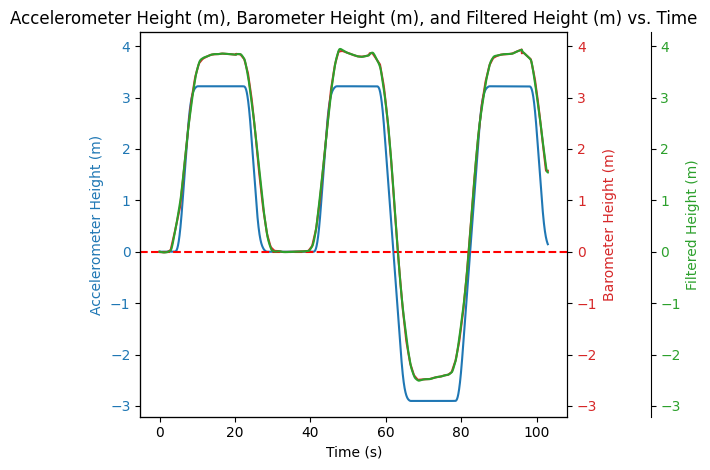

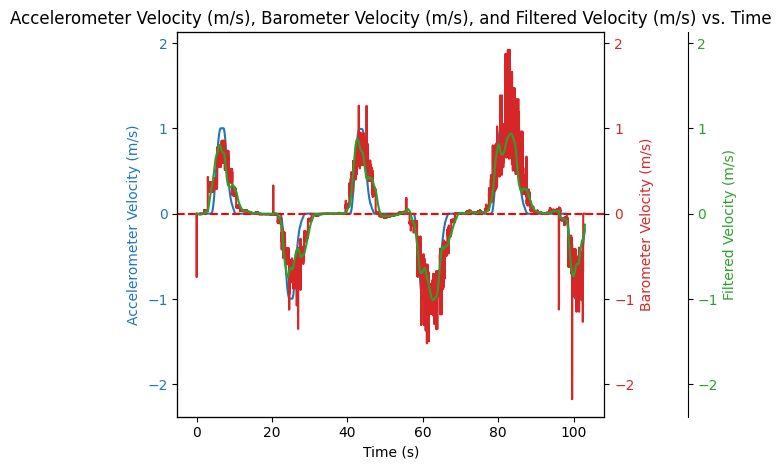

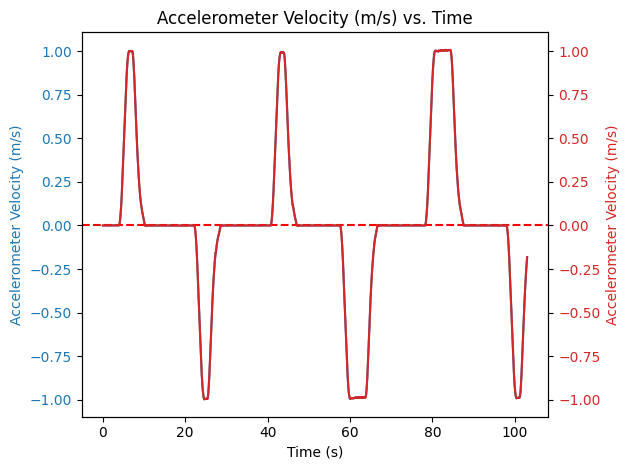

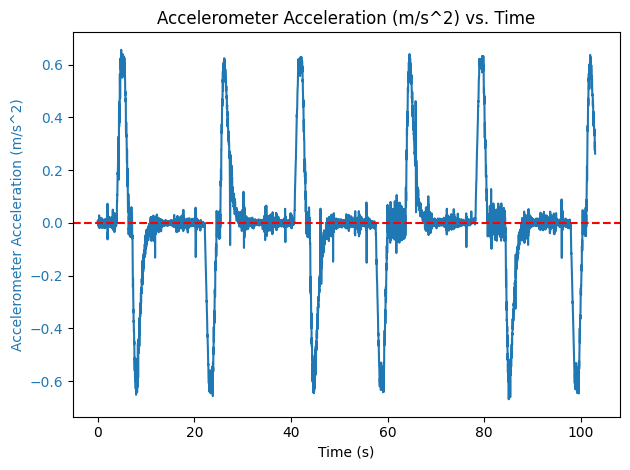

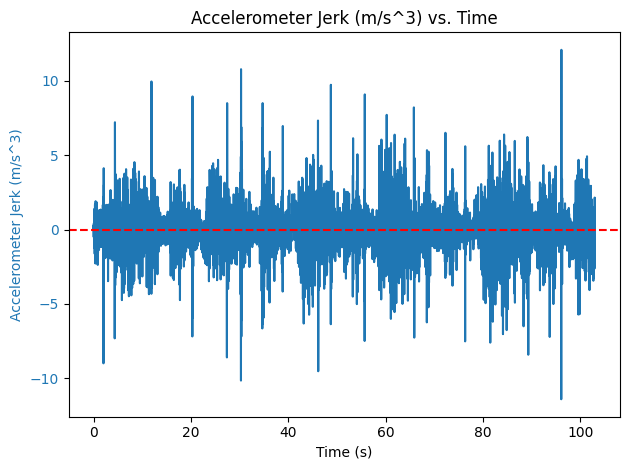

In [934]:
chart('aHeight', 'pHeight', 'eHeight')
chart('aVelocity', 'pVelocity', 'eVelocity')
chart('aVelocity', 'aVelocity')
chart('aAcc')
chart('aJerk')